In [1]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer

from pandas_profiling import ProfileReport

# Set up environment variables
project_id = 'genuine-box-350018'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


**MORTALITY LABELS**

In [3]:
mortality = run_query("""
SELECT *
FROM `genuine-box-350018.rnn_dataset.final-cohort-table`
""")
display(mortality)

/usr/local/lib/python3.7/dist-packages/google/cloud/bigquery/table.py:1582: FutureWarning: Data is timezone-aware. Converting timezone-aware data to timezone-naive by passing dtype='datetime64[ns]' to DataFrame or Series is deprecated and will raise in a future version. Use `pd.Series(values).dt.tz_localize(None)` instead.
  bqstorage_client=bqstorage_client, dtypes=dtypes


,subject_id,stay_id,hadm_id,intime,year,deathtime,death_status
0,10157718,30185469,24943658,2164-02-21 23:58:01+00:00,2009,NaT,0
1,10249925,32593030,28164030,2122-12-29 23:50:00+00:00,2009,NaT,0
2,10311956,36577532,25628815,2123-03-06 23:58:05+00:00,2009,NaT,0
3,10329846,35463345,28917992,2139-12-16 20:22:00+00:00,2009,NaT,0
4,10431718,36653742,20415490,2157-09-09 11:31:16+00:00,2009,NaT,0
...,...,...,...,...,...,...,...
21889,13393674,37425449,23351991,2121-05-07 00:42:09+00:00,2012,2121-05-09 17:03:00+00:00,1
21890,16131968,38118615,25993458,2136-07-14 12:28:45+00:00,2012,2136-07-17 14:50:00+00:00,1
21891,16483343,33171103,27615389,2117-02-07 02:06:25+00:00,2012,2117-03-16 01:55:00+00:00,1
21892,16734321,37307350,28193892,2111-02-17 14:51:00+00:00,2012,2111-02-24 07:00:00+00:00,1


In [43]:
print(mortality['year'].unique())

[2009 2010 2011 2012]


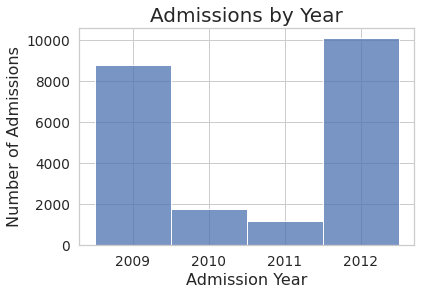

In [122]:
# Number of admissions each year
fig, ax = plt.subplots()
sns.set(style="whitegrid", font_scale=1)
sns.histplot(data=mortality, x='year',  bins=[2008.5,2009.5,2010.5,2011.5,2012.5], ax=ax)
ax.set_xticks(range(2009, 2013,1))
plt.xlabel("Admission Year", fontsize=16)
plt.ylabel("Number of Admissions", fontsize=16)
plt.title("Admissions by Year", fontsize=20)
plt.show(sns)

In [75]:
death_per_year = pd.DataFrame({"year": [2009, 2010, 2011, 2012],
                              "total_death": mortality.groupby('year').death_status.sum()})
display(death_per_year)

,year,total_death
year,,
2009,2009,673
2010,2010,94
2011,2011,50
2012,2012,675


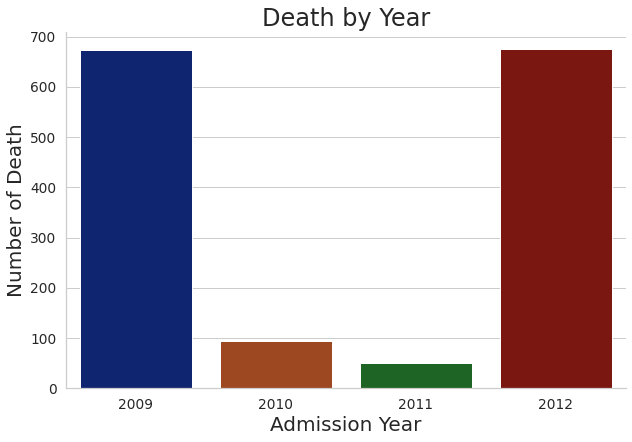

In [119]:
# Number of death each year
sns.set(style="whitegrid", font_scale=1.25)
sns.catplot(data=death_per_year, kind="bar", x="year", y="total_death",palette="dark", height=6, aspect=1.5)
plt.xlabel("Admission Year", fontsize=20)
plt.ylabel("Number of Death", fontsize=20)
plt.title("Death by Year", fontsize=24)
plt.show(sns)

**ICD-9 Codes**

In [5]:
icd_data = run_query("""
SELECT *
FROM `genuine-box-350018.rnn_dataset.icd-table`
""")
display(icd_data)

,subject_id,hadm_id,stay_id,icd_1,icd_2,icd_3,icd_4,icd_5,icd_6,icd_7,...,icd_11,icd_12,icd_13,icd_14,icd_15,icd_16,icd_17,icd_18,icd_19,icd_20
0,10001217,24597018,37067082,1,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,1,0
1,10002527,29112696,37121704,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
2,10002760,28094813,31831386,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,10003046,26048429,35514836,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10006633,25978757,32905915,0,1,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21887,19985683,25452614,36461568,0,1,1,0,0,1,1,...,0,1,0,0,1,0,0,1,1,1
21888,19985885,24999390,34175243,0,0,1,0,0,0,1,...,0,0,1,0,1,1,0,1,1,1
21889,19988137,22716260,33257394,0,0,1,1,0,0,0,...,1,0,0,0,0,0,0,1,1,1
21890,19991538,26694123,39801924,1,0,1,0,1,1,0,...,0,0,1,0,0,0,0,1,1,1


In [86]:
# Summing total of each ICD Columns
icd_per_group = pd.DataFrame({"ICD": ['ICD 1', 'ICD 2', 'ICD 3', 'ICD 4', 'ICD 5', 'ICD 6', 'ICD 7', 'ICD 8', 'ICD 9', 'ICD 10', 
                                  'ICD 11', 'ICD 12', 'ICD 13', 'ICD 14', 'ICD 15', 'ICD 16', 'ICD 17', 'ICD 18', 'ICD 19', 'ICD 20'],
                          "icd_total": icd_data.iloc[:,3:23].sum(axis=0)})
display(icd_per_group)

,ICD,icd_total
icd_1,ICD 1,6372
icd_2,ICD 2,4241
icd_3,ICD 3,16454
icd_4,ICD 4,9430
icd_5,ICD 5,9225
icd_6,ICD 6,9167
icd_7,ICD 7,18186
icd_8,ICD 8,10662
icd_9,ICD 9,9876
icd_10,ICD 10,9871


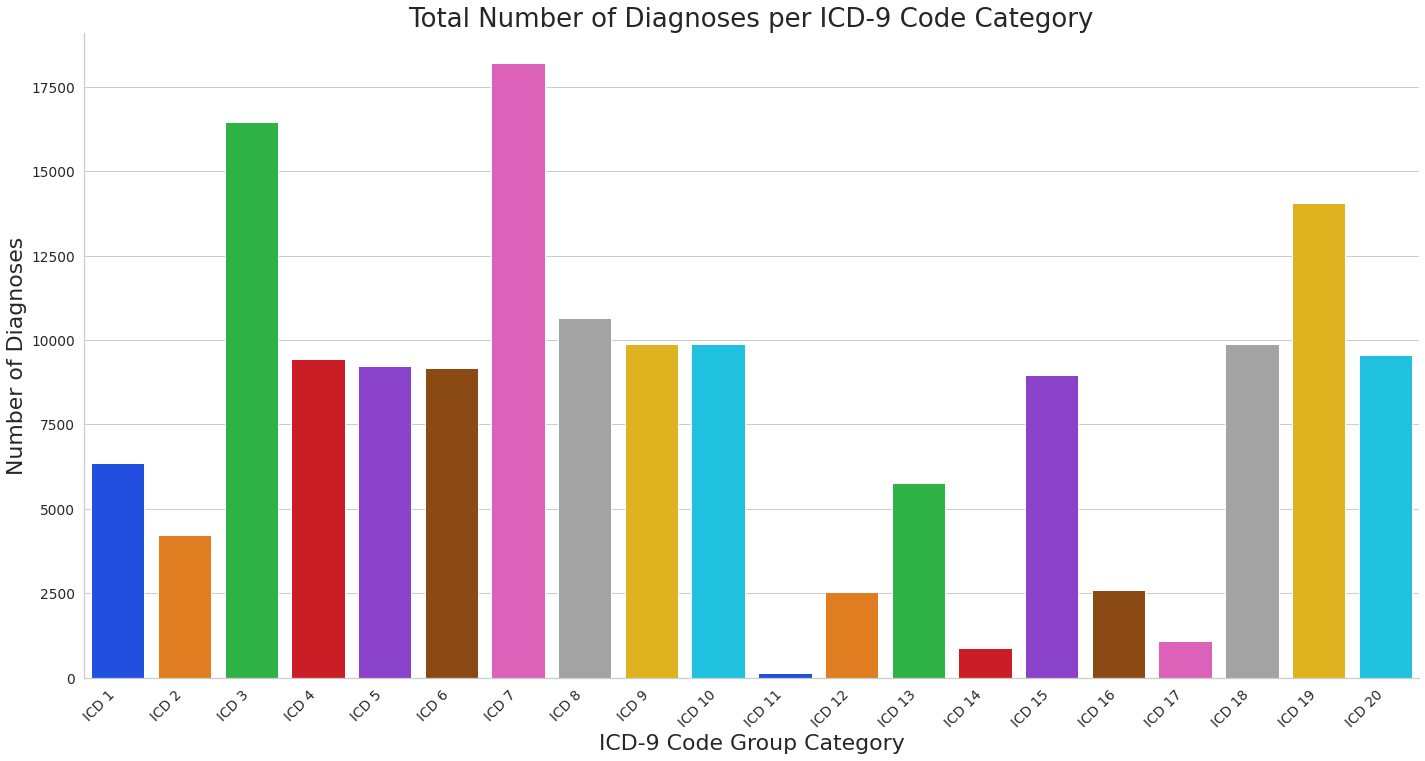

In [115]:
# Total number of diagnoses each ICD-9 code category
sns.set(style="whitegrid", font_scale=1.25)
sns.catplot(data=icd_per_group, kind="bar", x="ICD", y="icd_total",palette="bright", height=10, aspect=2)
plt.xticks(rotation=45, ha="right")
plt.xlabel("ICD-9 Code Group Category", fontsize=22)
plt.ylabel("Number of Diagnoses", fontsize=22)
plt.title("Total Number of Diagnoses per ICD-9 Code Category", fontsize=26)
plt.show(sns)
